In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from fruit_data import get_data, filelist_from_directory, create_dataset 

In [2]:
filelist = pd.read_csv('./Dataset_index/limited_training_5000_records.csv' )
X,y = create_dataset(filelist)
print('Data load complete')

Data load complete


In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y)

LabelEncoder()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y)

X_train = X_train/255
X_val = X_val/255
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)


### Model 1 - Conv NN

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

#Define a model:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(100,100,3)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(264, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(95, activation='softmax'))
     
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])  

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 98, 98, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 24, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 264)               2433288   
_________________________________________________________________
dropout_11 (Dropout)         (None, 264)               0         
__________

In [13]:
#checkpoint_path = './saved_models/model1/checkpoints.ckpt'
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
       #                                          save_weights_only=True,
        #                                         verbose=1)

history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    #callbacks = [cp_callback],
                    epochs=20)

Train on 3750 samples, validate on 1250 samples
Epoch 1/20
3750/3750 [==============================] - 127s 34ms/step - loss: 3.6678 - acc: 0.1528 - val_loss: 2.3742 - val_acc: 0.5080
Epoch 2/20
3750/3750 [==============================] - 5s 1ms/step - loss: 1.8704 - acc: 0.4925 - val_loss: 0.9353 - val_acc: 0.7888
Epoch 3/20
3750/3750 [==============================] - 5s 1ms/step - loss: 1.0724 - acc: 0.6755 - val_loss: 0.6752 - val_acc: 0.8128
Epoch 4/20
3750/3750 [==============================] - 5s 1ms/step - loss: 0.7150 - acc: 0.7845 - val_loss: 0.4058 - val_acc: 0.8984
Epoch 5/20
3750/3750 [==============================] - 5s 1ms/step - loss: 0.5091 - acc: 0.8456 - val_loss: 0.2111 - val_acc: 0.9392
Epoch 6/20
3750/3750 [==============================] - 5s 1ms/step - loss: 0.3803 - acc: 0.8768 - val_loss: 0.1415 - val_acc: 0.9592
Epoch 7/20
3750/3750 [==============================] - 5s 1ms/step - loss: 0.2973 - acc: 0.9019 - val_loss: 0.2014 - val_acc: 0.9384
Epoch 8/20


### Save a trained model

In [14]:
checkpoint_path = './saved_models/model1/trained_model'
model.save(checkpoint_path)

In [ ]:
model.load_weights()

In [15]:
model_json = model.to_json()
with open("./saved_models/model1/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 

Saved model to disk


In [18]:
filelist_test = pd.read_csv('./Dataset_index/limited_testing_1000_records.csv' )
X_test,y_test = create_dataset(filelist_test)

X_test = X_test/255
y_test = label_encoder.transform(y_test)


In [9]:
model.evaluate(X_test, y_test)

1000/1000 [==============================] - 1s 1ms/step


[0.6095312627553939, 0.912]

In [5]:
# Loss Curves
def plt_history(history):
    plt.figure(figsize=[20,8]);
    plt.subplot(1,2,1)

    plt.plot(history.history['loss'],'r',linewidth=3.0);
    plt.plot(history.history['val_loss'],'b',linewidth=3.0);
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Loss',fontsize=16);
    plt.title('Loss Curves',fontsize=16);

    # Accuracy Curves
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'],'r',linewidth=3.0);
    plt.plot(history.history['val_acc'],'b',linewidth=3.0);
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Accuracy',fontsize=16);
    plt.title('Accuracy Curves',fontsize=16);


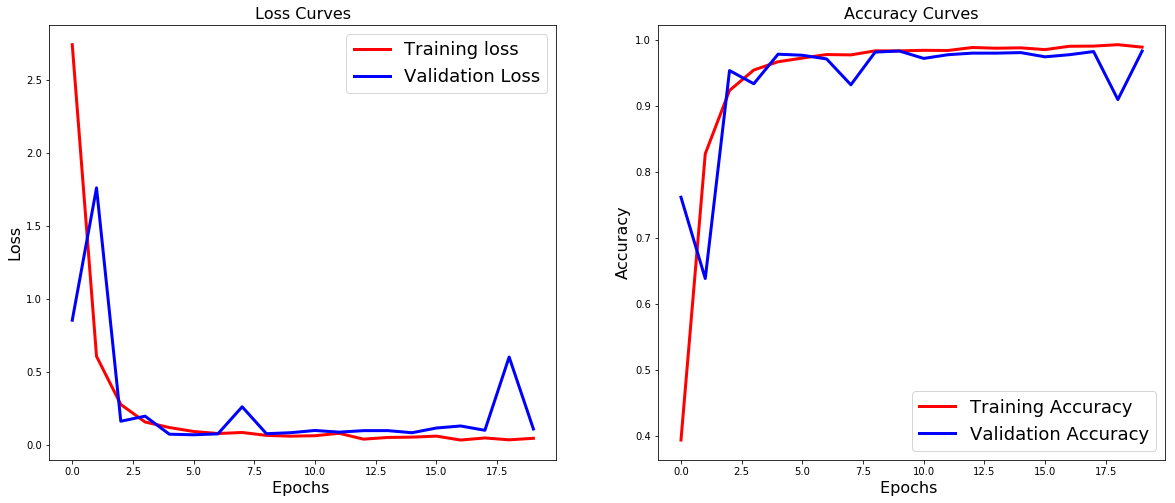

In [11]:
plt_history(history)

### Model 2 - Mobilenet transfer learning model

In [6]:
import tensorflow_hub as hub
#5s to load the model
module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2', \
                    trainable=True)


W0312 23:33:39.365547 12248 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [7]:
IMAGE_SIZE = hub.get_expected_image_size(hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2'))
print(IMAGE_SIZE)

[128, 128]


In [10]:
FeatureVector128 = tf.keras.layers.Lambda(module, input_shape = IMAGE_SIZE+[3])
model2 = tf.keras.Sequential([FeatureVector128] )
model2.add(Dense(95, activation='softmax'))
model2.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])  

model2.summary()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0313 00:20:44.340599 12248 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 95)                121695    
Total params: 121,695
Trainable params: 121,695
Non-trainable params: 0
_________________________________________________________________


In [12]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [16]:
n = 1000
X_train128 = tf.image.resize_images(X_train[0:n,:], (128,128)).eval(session=sess)
y_train128 = y_train[0:n]
print('training images resized')

m = 1000
X_val128 = tf.image.resize_images(X_val[0:m,:], (128,128)).eval(session=sess)
y_val128 = y_val[0:m]
print('test images resized')

In [33]:
#checkpoint_path = './saved_models/model2/checkpoints.ckpt'
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                 save_weights_only=True,
#                                                 verbose=1, period=5)

history = model2.fit(X_train128, y_train128,
                     validation_data = (X_val128, y_val128),
                     #callbacks=[cp_callback],
                    epochs=20)

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 38s 38ms/step - loss: 0.0859 - acc: 0.9960 - val_loss: 0.2433 - val_acc: 0.9430
Epoch 2/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0551 - acc: 0.9970 - val_loss: 0.2249 - val_acc: 0.9460
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0363 - acc: 0.9990 - val_loss: 0.1795 - val_acc: 0.9530
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0252 - acc: 1.0000 - val_loss: 0.1763 - val_acc: 0.9510
Epoch 5/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0181 - acc: 1.0000 - val_loss: 0.1841 - val_acc: 0.9550
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0132 - acc: 1.0000 - val_loss: 0.1727 - val_acc: 0.9480
Epoch 7/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.1660 - val_acc: 0.9530
Epoch 8/20
1

In [ ]:
history = model2.fit(X_train, y_train,
                     validation_data = (X_val, y_val),
                     #callbacks=[cp_callback],
                    epochs=20)

In [36]:
n = 1000
X_test128 = tf.image.resize_images(X_test[0:n,:], (128,128)).eval(session=sess)
y_test128 = y_test[0:n]

In [37]:
model2.evaluate(X_test128, y_test128)

1000/1000 [==============================] - 22s 22ms/step


[0.1988689669612795, 0.945]

In [40]:
model2.save_weights('model2.h5')

model_json = model2.to_json()
with open("model2_arch.json", "w") as json_file:
    json_file.write(model_json)


AttributeError: 'Module' object has no attribute '__name__'

# Model 3 - Resize as 1st layer of model

In [14]:
resize_layer = tf.keras.layers.Lambda(lambda x: tf.image.resize_images(x, (128,128)), input_shape = (100,100,3))
FeatureVector128 = tf.keras.layers.Lambda(module, input_shape = IMAGE_SIZE+[3])

model3 = tf.keras.Sequential()
model3.add(resize_layer)
model3.add(FeatureVector128)
model3.add(Dense(95, activation='softmax'))
model3.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])  

model3.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0313 00:24:12.121082 12248 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 95)                121695    
Total params: 121,695
Trainable params: 121,695
Non-trainable params: 0
_________________________________________________________________


In [15]:
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [16]:
history = model3.fit(X_train, y_train,
                     validation_data = (X_val, y_val),
                     #callbacks=[cp_callback],
                    epochs=10)

Train on 3750 samples, validate on 1250 samples
Epoch 1/10
3750/3750 [==============================] - 65s 17ms/step - loss: 1.3708 - acc: 0.7432 - val_loss: 0.3016 - val_acc: 0.9592
Epoch 2/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.1509 - acc: 0.9824 - val_loss: 0.0934 - val_acc: 0.9896
Epoch 3/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0509 - acc: 0.9957 - val_loss: 0.0457 - val_acc: 0.9912
Epoch 4/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0231 - acc: 0.9979 - val_loss: 0.0361 - val_acc: 0.9928
Epoch 5/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0127 - acc: 0.9995 - val_loss: 0.0230 - val_acc: 0.9960
Epoch 6/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0078 - acc: 0.9989 - val_loss: 0.0168 - val_acc: 0.9960
Epoch 7/10
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0048 - acc: 0.9997 - val_loss: 0.0117 - val_acc: 0.9976
Epoch 8/10
3

In [19]:
model3.evaluate(X_test, y_test)

1000/1000 [==============================] - 2s 2ms/step


[0.07481057525950019, 0.98]

# Data Augmentation code

In [30]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [31]:
model3.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=5,
                    validation_data = (X_val, y_val))

Epoch 1/5
118/117 [==============================] - 12s 104ms/step - loss: 5.8917 - acc: 0.5285 - val_loss: 3.7449 - val_acc: 0.6880
Epoch 2/5
118/117 [==============================] - 12s 99ms/step - loss: 2.3724 - acc: 0.7902 - val_loss: 1.8861 - val_acc: 0.8296
Epoch 3/5
118/117 [==============================] - 12s 99ms/step - loss: 1.4334 - acc: 0.8692 - val_loss: 1.2959 - val_acc: 0.8840
Epoch 4/5
118/117 [==============================] - 12s 98ms/step - loss: 1.0730 - acc: 0.9080 - val_loss: 1.0567 - val_acc: 0.9064
Epoch 5/5
118/117 [==============================] - 12s 99ms/step - loss: 0.9211 - acc: 0.9244 - val_loss: 0.9297 - val_acc: 0.9168


In [32]:
model3.evaluate(X_test, y_test)

1000/1000 [==============================] - 2s 2ms/step


[1.093194827687228, 0.886]

In [ ]:
plt_history(model3)

### CIFAR 100 dataset

In [90]:
from keras.datasets import cifar100

Using TensorFlow backend.


In [91]:
(X_cifar_train, y_cifar_train), (X_cifar_test, y_cifar_test) = cifar100.load_data()

169009152/169001437 [==============================] - 116s 1us/step


In [110]:
apples = X_cifar_train[(y_cifar_train==0)[:,0],:,:,:]

In [116]:
n = 500
apples_test128 = tf.image.resize_images(X_test[0:n,:], (128,128)).eval(session=sess)



In [118]:
label_encoder.inverse_transform(model2.predict_classes(apples_test128))

array(['Banana Lady Finger', 'Banana', 'Banana', 'Apricot',
       'Tomato Cherry Red', 'Mulberry', 'Tomato 4', 'Limes', 'Dates',
       'Cherry Rainier', 'Pear Monster', 'Grape Pink', 'Nectarine',
       'Cherry Rainier', 'Pear', 'Grape Pink', 'Tomato 1', 'Maracuja',
       'Cherry Wax Red', 'Tamarillo', 'Tomato Cherry Red',
       'Cherry Rainier', 'Clementine', 'Pineapple', 'Strawberry',
       'Redcurrant', 'Clementine', 'Apple Granny Smith', 'Mango',
       'Apricot', 'Tomato 2', 'Passion Fruit', 'Banana', 'Guava',
       'Chestnut', 'Apple Golden 3', 'Passion Fruit', 'Physalis',
       'Tomato 2', 'Pear Monster', 'Lemon', 'Tomato Cherry Red', 'Orange',
       'Tomato Cherry Red', 'Huckleberry', 'Apple Granny Smith',
       'Passion Fruit', 'Cherry Rainier', 'Cherry 1', 'Pear Monster',
       'Nectarine', 'Peach 2', 'Tomato Cherry Red', 'Hazelnut',
       'Huckleberry', 'Tomato 2', 'Grapefruit Pink', 'Peach Flat', 'Pear',
       'Cherry 1', 'Pitahaya Red', 'Cocos', 'Strawberry Wed

In [94]:
CIFAR100_LABELS_LIST = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]



## For the bin